# Photometry from gaia

> only with `prose >= 2.0.1`

In this case study, we will build the lightcurves of some gaia stars present in the field, based on sky coordinates. Unlike previous tutorial, we will not use the pre-built `Claibration` and `AperturePhotometry` pipelines but do it from sratch.

Here is the strategy for our pipeline:
- Query reference gaia stars in the reference image
- Align all images to this reference image
- Perform aperture photometry based on the reference stars positions

## Getting our images

In [1]:
from prose import FitsManager

trappist-south.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)
liverpool.telescope differs from builtins (use prose.CONFIG.update_builtins() to update)


In [2]:
fm = FitsManager("/Users/lgrcia/data/20220405")
fm.print(exposure=False)

RUN Parsing FITS: 100%|███████████████| 1423/1423 [00:01<00:00, 1005.68images/s]

╒═════════╤════════════╤═════════════╤═════════════╤══════════╤════════╤════════════╕
│   index │ date       │ telescope   │ target      │ filter   │ type   │   quantity │
╞═════════╪════════════╪═════════════╪═════════════╪══════════╪════════╪════════════╡
│       0 │ 2022-04-05 │ Europa      │ Sp1121-1313 │ I+z      │ light  │        174 │
├─────────┼────────────┼─────────────┼─────────────┼──────────┼────────┼────────────┤
│       1 │ 2022-04-05 │ Europa      │ Sp1552-2623 │ i'       │ light  │        638 │
├─────────┼────────────┼─────────────┼─────────────┼──────────┼────────┼────────────┤
│       2 │ 2022-04-05 │ Europa      │ TOI-4325.01 │ r'       │ light  │        540 │
╘═════════╧════════════╧═════════════╧═════════════╧══════════╧════════╧════════════╛
Calibrations:
╒════════════╤═════════════╤══════════╤══════════╤════════╤════════════╕
│ date       │ telescope   │ target   │ filter   │ type   │   quantity │
╞════════════╪═════════════╪══════════╪══════════╪════════╪═══════

## Picking a reference image

To align images we will select a reference image to work with. Generally one from the middle of your observation is good enough. 

<div class="alert alert-info">
    
Note

While it is for applications in difference imaging, I noticed [this paper](https://ui.adsabs.harvard.edu/abs/2021MNRAS.507.1836W/abstract) about reference selection
</div>

In [3]:
from prose import Image

files = fm.observation_files(0)
ref = Image(files['images'][100])

We now build a sequence to calibrate the image and detect the reference stars. This sequence can be reused later to calibrate the other images

INFO Building master bias
INFO Building master dark
INFO Building master flat


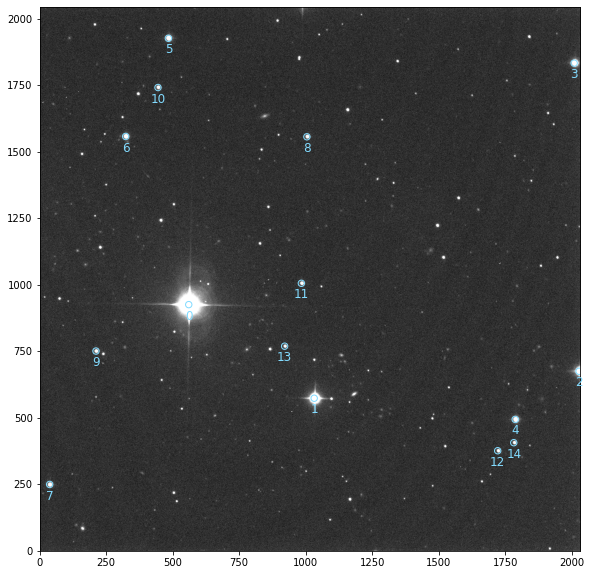

In [4]:
from prose import Sequence, blocks

calibration = Sequence([
    blocks.Calibration(files['darks'], files['flats'], files['bias']),
    blocks.Trim(),
    blocks.SegmentedPeaks(n_stars=15), # low number of stars usually enough for alignment
    blocks.detection.LimitStars()
])

calibration.run(ref, show_progress=False)
ref.show()

<div class="alert alert-info">
Note
    
Since our telescope is set, trimming dimensions don't need to be specified. Which is why the `Trim` block has no kwargs
</div>

## Detecting Gaia stars

Since our strategy is to rely on reference gaia stars, let's find them in the reference image

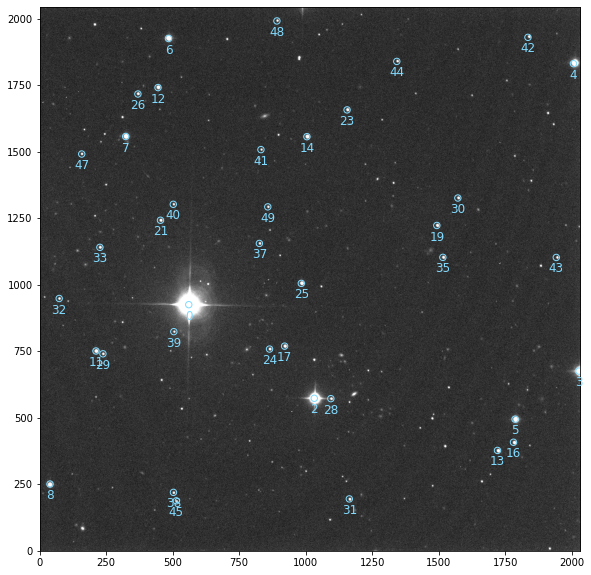

In [6]:
gaia = Sequence([
    blocks.catalogs.PlateSolve(),
    blocks.catalogs.GaiaCatalog(limit=50, mode="replace")
])

gaia.run(ref, show_progress=False)
ref.show()

with `mode="replace"` the stars queried from gaia replaced the `Image.stars_coords`

## The reduction sequence

We can now build the complete reduction sequence

In [7]:
reduction = Sequence([
    *calibration,                    # the simple calibration sequence previously built
    blocks.Twirl(ref.stars_coords),  # compute the transformation from reference stars
    blocks.Cutouts(),                # making stars cutouts
    blocks.MedianPSF(),              # building PSF
    blocks.Moffat2D(),               # modeling PSF
    
    # setting stars to the reference ones
    blocks.Set(stars_coords=ref.stars_coords),
    # and transform them to match reference
    blocks.AffineTransform(data=False, inverse=True),
    
    blocks.BalletCentroid(),              # stars centroiding
    blocks.PhotutilsAperturePhotometry(), # photometry
    
    # Retrieving data from images in a conveniant way
    blocks.XArray(
        (("time"), "jd_utc"),
        (("time", "apertures", "star"), "fluxes"),
        (("time", "apertures", "star"), "errors"),
    ),
])

reduction.run(files['images'])

RUN 100%|█████████████████████████████████| 174/174 [00:43<00:00,  4.03images/s]

WARNING LimitStars discarded images 0, 1, 2, 3, 4


here some images have been discarded. By taking a closer look we would see that these images were faulty, sometimes without any stars detectable. This is quite common from ground based observations as clouds and pointing errors may happen

## Getting the light curves

In order to instantiate an `Observation` object, we need to retrieve the data from this sequence, mostly stored in the `XArray` block

In [8]:
from prose import utils

xarr = reduction[-1].xarray # where the data lie
xarr = utils.image_in_xarray(ref, xarr, stars=True) # adding reference as a stack
xarr = xarr.transpose("apertures", "star", "time", ...) # ... just needed

We can now instantiate an `Observation` object and build light-curves as we want

INFO Could not convert time to BJD TDB


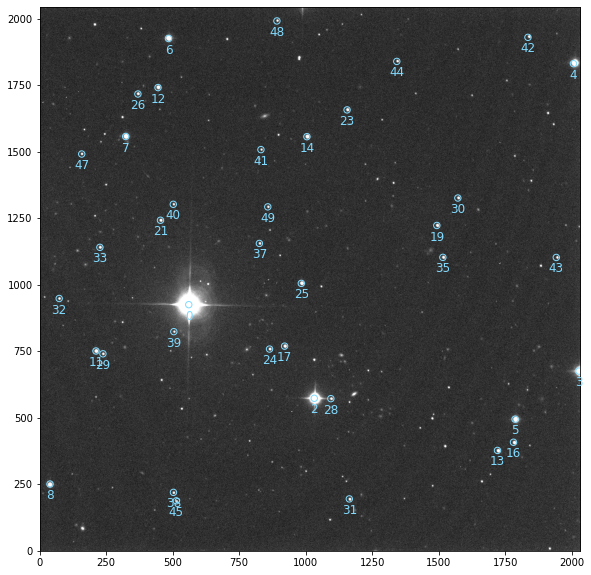

In [9]:
from prose import Observation

obs = Observation(xarr)
obs.show_stars()

(0.98, 1.02)

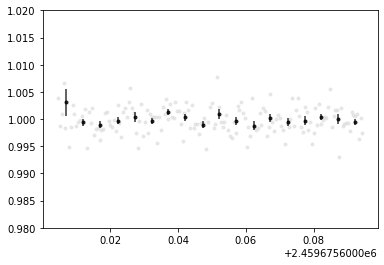

In [20]:
import matplotlib.pyplot as plt

obs.target = 14 # for example
obs.broeg2005() # differential photometry
obs.plot()

plt.ylim(0.98, 1.02)